In [1]:
from timeit import default_timer as timer

import numpy as np
import matplotlib.pyplot as plt


# Download Apical Neuron Data

In [2]:
from lims_apical_queries import get_benchmark_apical, get_all_intact_apical
data, _ = get_benchmark_apical()

len(data)

190

In [3]:
def plot_pia_wm_soma(sdata, ax=None):
    if not ax:
        _, ax = plt.subplots()

    ax.plot(sdata['pia_coords']['x'], sdata['pia_coords']['y'])
    ax.plot(sdata['wm_coords']['x'], sdata['wm_coords']['y'])
    ax.scatter(sdata['soma_center'][0], sdata['soma_center'][1], s=10)
    ax.legend(['pia', 'wm', 'soma'])
    return ax

## Calculate True Upright Angle from Apical Dendrite

In [4]:
# Adapted from Nathan Gouwens git morph_features/morph_features/apical_projection.py
from neuron_morphology.constants import APICAL_DENDRITE
import scipy.spatial.distance as distance

def apical_trunk_line(apical_trunk):
    x = np.array([c["x"] for c in apical_trunk])
    y = np.array([c["y"] for c in apical_trunk])
    z = np.array([c["z"] for c in apical_trunk])

    data = np.vstack([x, y, z]).T
    mu = data.mean(axis=0)
    uu, dd, vv = np.linalg.svd(data - mu)
    dist = distance.euclidean(data[0, :], data[-1, :])

    linepts = vv[0] * np.mgrid[-dist/2.:dist/2.:2j][:, np.newaxis]
    linepts += mu

    return data, linepts


def identify_apical_trunk(morph, stopping_fraction=1.5):

    # find nodes along the max path until a branch where the longer path 
    # is less than stopping_fraction * the shorter path

    soma = morph.get_root()

    # max_dist[node_id] = maximum distance to leaf
    max_dist = {} 
    # path[node_id] = next_node_id where next_node_id is on the maximum path 
    # and stopping ratio hasn't been reached
    path = {}          
    to_visit = [soma]
          
    # Bottom up get max path
    while to_visit:
        node = to_visit.pop()
        children = morph.get_children(node, node_types=[APICAL_DENDRITE])
        if children:
            if all([child['id'] in max_dist for child in children]):
                if len(children) > 1:
                    shortest = (None, None)
                    longest = (None, None)
                    for child in children:
                        distance = max_dist[child['id']] + \
                            morph.get_compartment_length(morph.get_compartment_for_node(child))
                        if not shortest[0] or distance < shortest[0]:
                            shortest = (distance, child)
                        if not longest[0] or distance > longest[0]:
                            longest = (distance, child)

                    ratio = longest[0] / shortest[0]
                    max_dist[node['id']] = longest[0]
                    if ratio > stopping_fraction:
                        path[node['id']] = longest[1]['id']
                    else:
                        path[node['id']] = None
                else:
                    child = children[0]
                    max_dist[node['id']] = max_dist[child['id']] + \
                            morph.get_compartment_length(morph.get_compartment_for_node(child))
                    path[node['id']] = child['id']
            else:
                to_visit.append(node)
                for child in children:
                    if child['id'] not in max_dist:
                        to_visit.append(child) 
        else:
            path[node['id']] = None
            max_dist[node['id']] = 0

    # Traverse path, adding nodes to trunk
    child_id = path[soma['id']]          
    trunk = []
    while child_id:
        trunk.append(morph.node_by_id(child_id))
        child_id = path[child_id]
    return trunk

def signed_angle_between(v1, v2):
    return np.arctan2(v1[0] * v2[1] - v1[1] * v2[0], v1[0] * v2[0] + v1[1] * v2[1])


def get_theta_from_apical_trunk(morphology):
    apical_trunk = identify_apical_trunk(morphology)
    _, linepts = apical_trunk_line(apical_trunk)
    linepts = linepts.T

    vec = np.array([linepts[0, 1] - linepts[0, 0], linepts[1, 1] - linepts[1, 0]])
    theta = signed_angle_between(vec, [0, 1])
    return theta    

### Calculate angle for all data, removing invalid morphologies

In [5]:
from neuron_morphology.swc_io import morphology_from_swc
from neuron_morphology.validation.result import InvalidMorphology

n_data = len(data)
print(f'Estimated time to complete: {n_data / 120:.2f} mins (~0.5 seconds per neuron)')

start_time = timer()

apical_upright_results = {}
invalid_ids = []
for sid, sdata in data.items():
    try:
        morphology = morphology_from_swc(sdata['swc_file'])
        apical_upright_results[sid] = get_theta_from_apical_trunk(morphology)
    except InvalidMorphology as e:
        invalid_ids.append(sid)

invalid_morphologies = {sid: data.pop(sid) for sid in invalid_ids}

end_time = timer()
run_time = end_time - start_time
print(f'Elapsed time: {run_time / 60:.2f} mins ({run_time / n_data:.2f} seconds per neuron)')
print(f'{len(invalid_morphologies)} morphologies were rejected')



Estimated time to complete: 1.58 mins (~0.5 seconds per neuron)
Elapsed time: 1.30 mins (0.41 seconds per neuron)
6 morphologies were rejected


### Remove some outliers

In [6]:
outlier_ids = [323865917, 325941643, 469704261, 471758398, 479225052, 501847931, 560678143, 589128331]
try:
    outlier_apicals = {sid: data.pop(sid) for sid in outlier_ids}
    outlier_apical_upright_results = {sid: apical_upright_results.pop(sid) for sid in outlier_ids}
except KeyError as e:
    pass


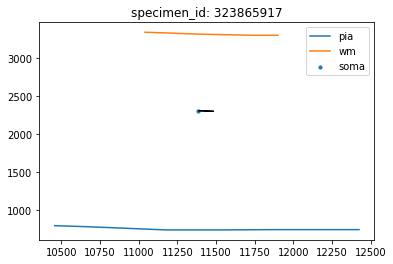

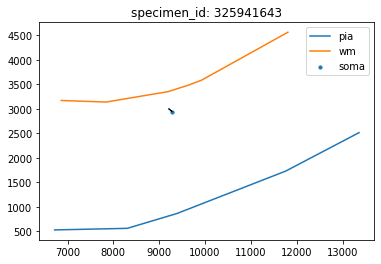

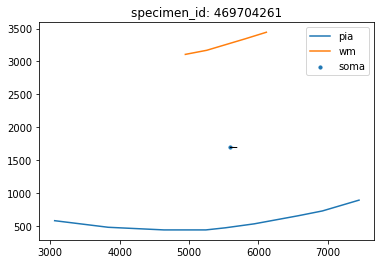

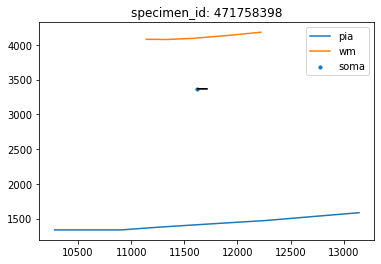

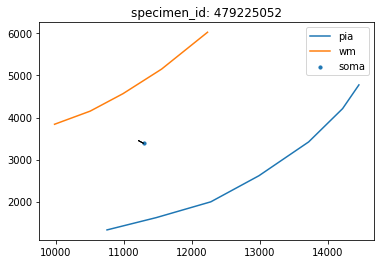

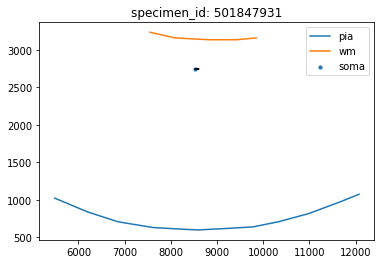

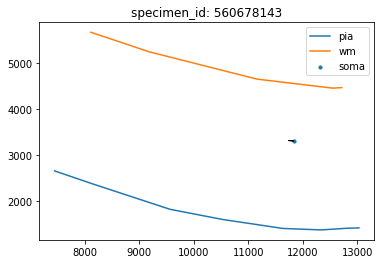

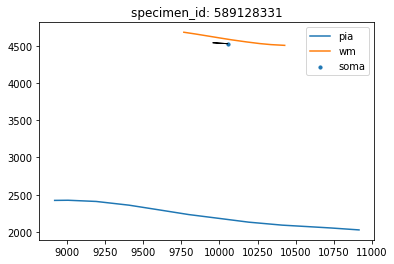

In [7]:
for sid in outlier_ids:
    sdata = outlier_apicals[sid]
    fig, ax = plt.subplots()
    plot_pia_wm_soma(sdata, ax=ax)
    
    apical_angle = outlier_apical_upright_results[sid]
    dx = 100 * np.cos(apical_angle)
    dy = 100 * np.sin(apical_angle)
    ax.arrow(sdata['soma_center'][0], sdata['soma_center'][1], dx, dy)
    ax.set_title(f'specimen_id: {sid}')
plt.show()

# Test Upright Methods

In [9]:
def as_deg_str(rad):
    return f'{np.degrees(rad):.2f}'

def hist_errors(method_name, method_results, apical_upright_results, outlier_threshold=15):
    errs = {sid: np.degrees(method_results[sid] - apical_upright_results[sid])
             for sid in apical_upright_results.keys()}
    errs = {sid: np.minimum(360 - err, err) for sid, err in errs.items()}
    

    fig, ax = plt.subplots()
    ax.hist(errs.values(), 50, density=True, facecolor='g', alpha=0.75)
    ax.set_xlabel('Angle Error (Deg)')
    ax.set_ylabel('Probability')
    ax.set_title(f'Histogram of {method_name} compared to Apical Upright')
    plt.show()
    
    outliers = {sid: {'Apical': as_deg_str(apical_upright_results[sid]),
                      method_name: as_deg_str(method_results[sid]),
                      'Error': err
                     }
                for sid, err in errs.items() if err > outlier_threshold}
    
    errs_arr = np.asarray(list(errs.values()))
    stats = {
    'mean_err': np.mean(errs_arr),
    'std_err': np.std(errs_arr),
    'mean_abs_err': np.mean(np.abs(errs_arr)),
    'std_abs_err': np.std(np.abs(errs_arr)),
    'rmse': np.sqrt(np.mean(errs_arr**2)),
    }
    
    return stats, outliers


## Method 1: Perpendicular to Pia

In [10]:
from neuron_morphology.transforms.upright_transform import convert_coords_str, project_to_polyline

perp_pia_results = {}

def perpendicular_to_pia(sdata):
    proj = project_to_polyline(sdata['pia_coords'], sdata['soma_center'])
    theta = np.arctan2((proj[1] - sdata['soma_center'][1]),
                       (proj[0] - sdata['soma_center'][0]))
    theta = np.pi /2 - theta
    return theta


for sid, sdata in data.items():
    perp_pia_results[sid] = perpendicular_to_pia(sdata)

### Errors Stats

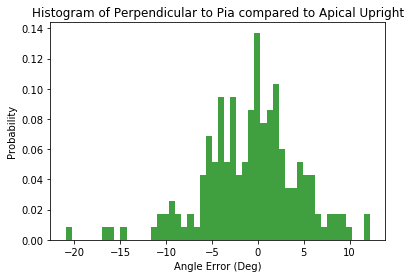

{'mean_err': -0.7877022293381392,
 'std_err': 5.216020002670481,
 'mean_abs_err': 3.9593309127825296,
 'std_abs_err': 3.4858339308474666,
 'rmse': 5.275162506535969}

In [11]:
stats, _ = hist_errors('Perpendicular to Pia', perp_pia_results, apical_upright_results)

stats

## Method 2: Ray Trace (shortest distance from wm to pia through soma)

In [12]:
from allensdk.internal.pipeline_modules.cell_types.morphology.upright_transform import calculate_shortest

n_data = len(data)
print(f'Estimated time to complete: {n_data / 2} mins (~30 seconds per neuron)')

ray_trace_results = {}

def ray_trace(sdata):
    px, py, wx, wy = calculate_shortest(sdata['soma_center'][0], sdata['soma_center'][1],
                                        sdata['pia_path_str'], sdata['wm_path_str'])
    
    if not px or not py or not wx or not wy:
        return float('NaN')
    
    theta = np.pi /2 - np.arctan2((py - wy), (px - wx))
    return theta


start_time = timer()
for i, (sid, sdata) in enumerate(data.items()):
    ray_trace_results[sid] = ray_trace(sdata)
    if i % 10 == 0:
        print(f'neuron: {i} - '
              f'elapsed_time: {(timer() - start_time) / 60:.2f} mins - '
              f'{(i / n_data * 100):.2f}% complete')

end_time = timer()
run_time = end_time - start_time
print(f'Elapsed time: {run_time / 60} mins ({run_time / n_data} seconds per neuron)')

Estimated time to complete: 88.0 mins (~30 seconds per neuron)
neuron: 0 - elapsed_time: 0.14 mins - 0.00% complete
neuron: 10 - elapsed_time: 2.47 mins - 5.68% complete
neuron: 20 - elapsed_time: 5.11 mins - 11.36% complete
neuron: 30 - elapsed_time: 7.35 mins - 17.05% complete
neuron: 40 - elapsed_time: 9.76 mins - 22.73% complete
neuron: 50 - elapsed_time: 15.56 mins - 28.41% complete
neuron: 60 - elapsed_time: 19.86 mins - 34.09% complete
neuron: 70 - elapsed_time: 24.66 mins - 39.77% complete
neuron: 80 - elapsed_time: 31.02 mins - 45.45% complete
neuron: 90 - elapsed_time: 35.45 mins - 51.14% complete
neuron: 100 - elapsed_time: 41.11 mins - 56.82% complete
neuron: 110 - elapsed_time: 43.73 mins - 62.50% complete
neuron: 120 - elapsed_time: 47.31 mins - 68.18% complete
neuron: 130 - elapsed_time: 51.87 mins - 73.86% complete
neuron: 140 - elapsed_time: 56.02 mins - 79.55% complete
neuron: 150 - elapsed_time: 59.23 mins - 85.23% complete
neuron: 160 - elapsed_time: 62.71 mins - 90

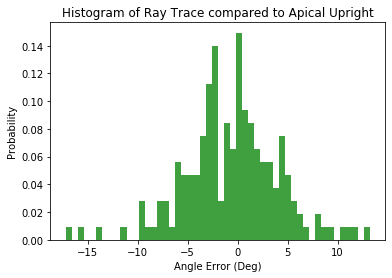

{'mean_err': -0.6081197933006816,
 'std_err': 4.762177917987283,
 'mean_abs_err': 3.6240250238352485,
 'std_abs_err': 3.1487443262649455,
 'rmse': 4.800848696383771}

In [13]:
stats, _ = hist_errors('Ray Trace', ray_trace_results, apical_upright_results)

stats